# Importing Libraries

In [1]:
import os
import cv2
import glob as gb
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px
import requests
from io import BytesIO
import zipfile
import os
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Tensorflow
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# metrics
from sklearn.metrics import classification_report, confusion_matrix

2024-03-10 16:23:05.484212: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 16:23:05.484349: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 16:23:05.620006: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Reading and formatting data

In [2]:
# Your label mapping and file paths
labels = {
    'buildings': 0,
    'forest': 1,
    'glacier': 2,
    'mountain': 3,
    'sea': 4,
    'street': 5
}

train_folder = r"/kaggle/input/intel-image-classification/seg_train/seg_train"
test_folder = r"/kaggle/input/intel-image-classification/seg_train/seg_train"

# Load training data
train_img = []
train_lbl = []

# Define common size for resizing
common_size = (224, 224)

for folder in os.listdir(train_folder):
    folder_path = os.path.join(train_folder, folder)
    files = gb.glob(pathname=os.path.join(folder_path, "*.jpg"))
    for file in files:
        image = Image.open(file)
        image = image.resize(common_size)  # Resize image to a common size
        train_img.append(np.array(image))
        train_lbl.append(labels.get(folder, -1))

train_img = np.array(train_img)
train_lbl = np.array(train_lbl)

# Load testing data
test_img = []
test_lbl = []
for folder in os.listdir(test_folder):
    folder_path = os.path.join(test_folder, folder)
    files = gb.glob(pathname=os.path.join(folder_path, "*.jpg"))
    for file in files:
        image = Image.open(file)
        image = image.resize(common_size)  # Resize image to a common size
        test_img.append(np.array(image))
        test_lbl.append(labels.get(folder, -1))

test_img = np.array(test_img)
test_lbl = np.array(test_lbl)

# Check the number of items in each set and their shapes
print("Number of items in the training set:", len(train_img))
print("Number of items in the testing set:", len(test_img))

Number of items in the training set: 14034
Number of items in the testing set: 14034


In [3]:
print("Shape of train_img:", train_img.shape)
print("Shape of train_lbl:", train_lbl.shape)
print("Shape of test_img:", test_img.shape)
print("Shape of test_lbl:", test_lbl.shape)

Shape of train_img: (14034, 224, 224, 3)
Shape of train_lbl: (14034,)
Shape of test_img: (14034, 224, 224, 3)
Shape of test_lbl: (14034,)


# Sample data

In [4]:
plt.figure(figsize=(18, 18))

random_list = random.sample(range(13001), 25)
i = 0
for j in random_list:
    plt.subplot(5, 5, i+1)
    plt.imshow(train_img[j])
    label_code = train_lbl[j]
    label_name = [key for key, value in labels.items() if value == label_code][0]
    plt.title(label_name)
    plt.xticks([])
    plt.yticks([])
    i+=1

plt.show()

# Preprocessing and Modeling

In [5]:

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32 , kernel_size=(5,5),
                           strides=(1,1), padding="same", activation="relu",
                           input_shape=train_img[0].shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=64 , kernel_size=(5,5),activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 108, 108, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,942,598 (91.33 MB)

 Trainable params: 23,942,534 (91.33 MB)

 Non-trainable params: 64 (256.00 B)

Ploting the Model

In [6]:
tf.keras.utils.plot_model(model, '/kaggle/working/model.png', show_shapes=True)

In [7]:
model.compile(optimizer="adam" , loss='sparse_categorical_crossentropy',metrics=['accuracy'])
early = EarlyStopping(patience=5, restore_best_weights=True)
# Train the model
history = model.fit(train_img, train_lbl, epochs=20, validation_data=(test_img, test_lbl), callbacks=[early])

Epoch 1/20
  5/439 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.2145 - loss: 94.6787

I0000 00:00:1710087923.787392      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


439/439 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - accuracy: 0.3964 - loss: 11.8993 - val_accuracy: 0.5909 - val_loss: 1.0214
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.6121 - loss: 1.0070 - val_accuracy: 0.5463 - val_loss: 1.2835
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.6741 - loss: 0.7992 - val_accuracy: 0.5762 - val_loss: 1.0554
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.7163 - loss: 0.7077 - val_accuracy: 0.7029 - val_loss: 0.8363
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.7921 - loss: 0.5758 - val_accuracy: 0.8238 - val_loss: 0.5384
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.8436 - loss: 0.4301 - val_accuracy: 0.8908 - val_loss: 0.3216
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.8784 - loss: 0.3440 - val_accuracy: 0.8038 - val_loss: 0.5902
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.8969 - loss: 0.3038 - val_accura

# Model Evaluation

In [8]:
loss , acc = model.evaluate(train_img , train_lbl)
print("Accuracy : ",acc)
print("loss : " , loss)

439/439 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9775 - loss: 0.0593
Accuracy :  0.9830411672592163
loss :  0.04763083532452583


In [9]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)
val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_loss = f'Best Epoch = {str(index_acc +1)}'

#Training Accuracy
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue' , label= loss_label)
plt.title('Training Vs Validation (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
plt.plot(epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc , val_highest , s= 150 , c= 'blue' , label = acc_loss)
plt.title('Training Vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show();

# Model Prediction

In [10]:
folder_pred = r"/kaggle/input/intel-image-classification/seg_pred"

for folder in os.listdir(folder_pred):
    folder_files = os.path.join(folder_pred, folder)
    files = gb.glob(pathname=os.path.join(folder_files, "*.jpg"))
    print(f"For files in folder {folder}, the number of items is {len(files)}")

For files in folder seg_pred, the number of items is 7301


In [11]:
def get_key_from_value(dictionary, value):
    return next((key for key, val in dictionary.items() if val == value), None)


439/439 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
[2 3 3 ... 2 2 2]


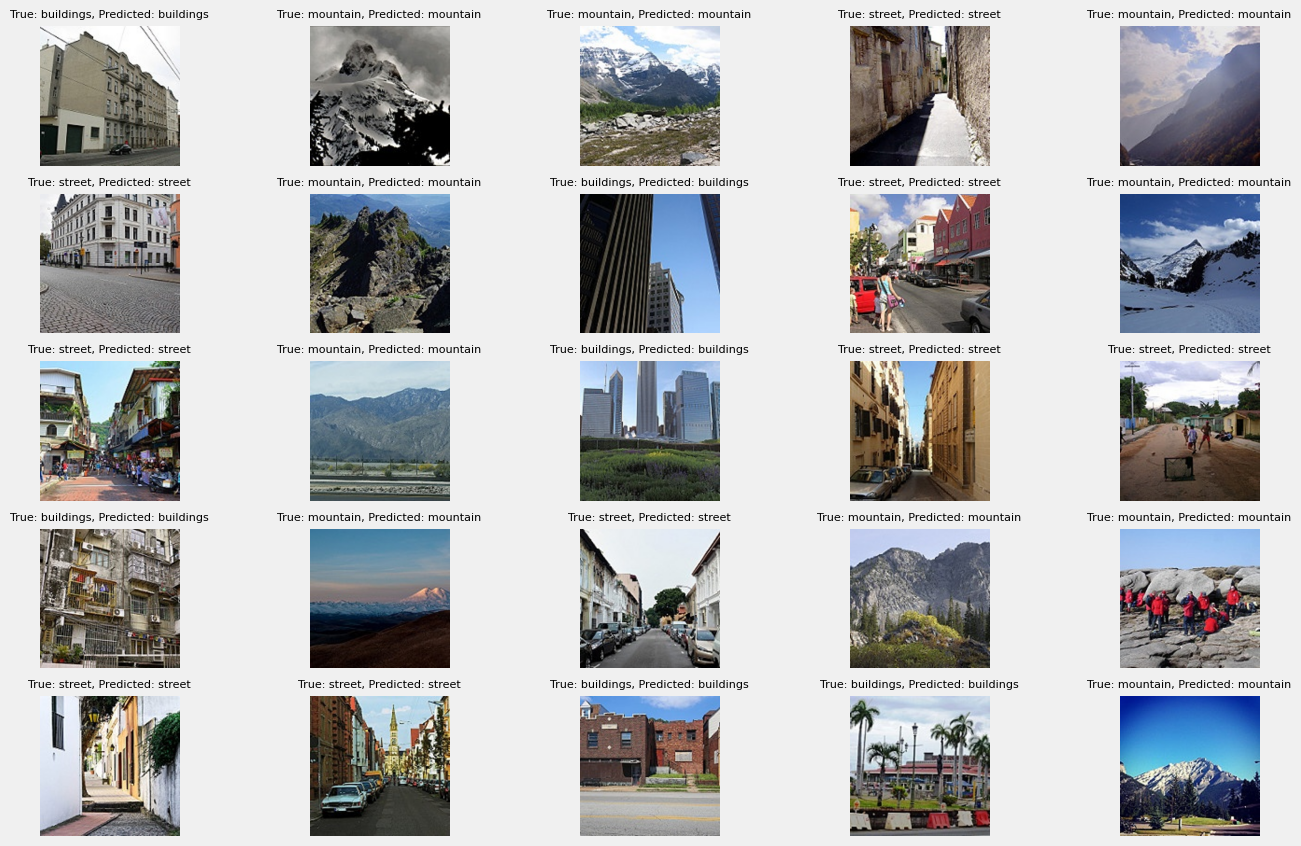

In [12]:
predictions = model.predict(test_img)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

print(predicted_classes)

# Visualize the predictions
plt.figure(figsize=(15, 10))
random_list2 = random.sample(range(7001), 25)
j=0
for i in random_list2: 
    plt.subplot(5, 5, j + 1)
    plt.imshow(test_img[i], cmap='gray')
    label1 = get_key_from_value(labels, test_lbl[i])
    label_code = test_lbl[i]
    label_name = [key for key, value in labels.items() if value == label_code][0]
    
    plt.title(f"True: {label1}, Predicted: {label_name}", fontsize=8)
    plt.axis('off')
    j+=1
plt.show()

In [13]:
model.save("model.h5") # saving the model

# Confusion matrix and Classification report

In [14]:
# Create confusion matrix
cm = confusion_matrix(test_lbl, predicted_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels.values(), yticklabels=labels.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Extract class labels in the correct order
class_labels = list(labels.keys())

# Print classification report
print("\nClassification Report:")
print(classification_report(test_lbl, predicted_classes, target_names=class_labels))


Classification Report:
              precision    recall  f1-score   support

   buildings       0.98      0.99      0.99      2191
      forest       1.00      0.99      0.99      2271
     glacier       0.98      0.99      0.98      2404
    mountain       0.99      0.97      0.98      2512
         sea       0.99      0.97      0.98      2274
      street       0.95      1.00      0.98      2382

    accuracy                           0.98     14034
   macro avg       0.98      0.98      0.98     14034
weighted avg       0.98      0.98      0.98     14034

